In [2]:
import torch
from PIL import Image
from IPython.display import display
from GradCam import GradCamForVQA
from vqa.ResnetVQA import VQAProcessor, VisualResnetForQuestionAnswering, wrap_model

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
processor = VQAProcessor('vqa/models/processor.pth', device)
model = VisualResnetForQuestionAnswering(processor, device)
model = wrap_model(model)

In [5]:
layer = model.module.module.resnet_layer4.r_model.layer4

In [11]:
from turtle import forward
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib as mpl
import numpy as np


from torchvision import transforms
from PIL import Image
from typing import Union, List


class GradCamForVQA(nn.Module):

    def __init__(self, model: nn.Module, layer: nn.Module, processor: nn.Module, device: torch.device) -> None:
        super(GradCamForVQA, self).__init__()
        self.device = device
        self.model = model.to(device)
        self.model.eval()

        if torch.backends.cudnn.enabled:
            print("Cannot peform backprop on RNN if torch.backends.cudnn.enabled")
            print("Disabling...")
        torch.backends.cudnn.enabled = False
        self.layer = layer

        self.gradients = None
        self.tensor_hook = None
        self.activation_maps = None

        def forward_hook(model: nn.Module, inp: torch.Tensor, out: torch.Tensor) -> None:
            self.activation_maps = out
            self.tensor_hook = self.activation_maps.register_hook(
                self.backward_hook)

        self.layer_hook = self.layer.register_forward_hook(forward_hook)
        self.processor = processor

    def backward_hook(self, grad: torch.Tensor) -> None:
        self.gradients = grad

     

In [12]:
gc = GradCamForVQA(model, layer, processor, device)

In [13]:
image = Image.open("/data/hyeongchanim/Grad-CAM/sample_images/vqa_images/test/texting.jpg")
question = "What is she doing?"

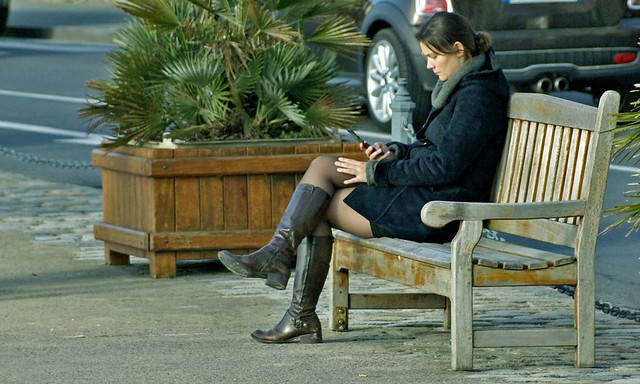

Question: What is she doing?
Answer: texting
tensor([[[[-1.1772e-05, -7.6774e-06, -3.5194e-06,  ..., -2.4690e-04,
           -3.5615e-05, -7.2386e-06],
          [-1.4451e-06, -5.1401e-06, -2.1434e-06,  ..., -7.3533e-05,
           -1.4402e-04, -2.1467e-05],
          [-2.0366e-06, -5.3330e-06, -3.7164e-05,  ..., -9.5098e-05,
           -1.9473e-04, -1.3885e-05],
          ...,
          [-2.3326e-04, -5.3028e-04, -4.9517e-04,  ..., -1.6571e-04,
           -3.8658e-05, -9.1696e-05],
          [-1.3636e-04, -2.1753e-04, -3.7943e-04,  ..., -1.2238e-04,
           -1.1103e-04, -5.5815e-05],
          [-1.0966e-05, -5.5626e-05, -1.8982e-04,  ..., -6.5529e-05,
           -2.2683e-04, -2.8242e-04]],

         [[ 5.2269e-06,  2.9517e-06,  8.4679e-07,  ...,  1.4659e-04,
            1.1932e-05,  1.8516e-06],
          [ 5.4609e-07,  1.6191e-06,  1.2265e-07,  ...,  6.1475e-05,
            1.0028e-04,  2.7065e-06],
          [ 1.6790e-06,  9.5812e-07,  1.3079e-05,  ...,  6.3816e-05,
            1

/tmp/ipykernel_1418440/3544386523.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = mpl.cm.get_cmap('jet', 256)


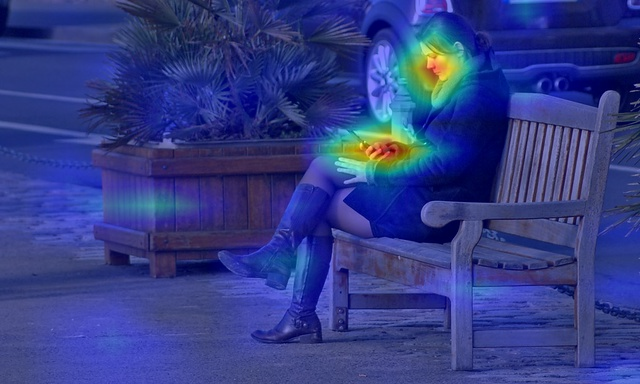

In [14]:
display(image)
print(f"Question: {question}")
gc(image, question)